In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
import torch
import torch.nn as nn
import re
from utils_notebook import histogram_experiment, dataframe_to_latex

In [2]:
results_path = "../results/all_db_all_training"


In [3]:
full_results_df = pd.DataFrame()
# For all folder in results_path
for experiment_folder in os.listdir(results_path):
    # Load the data
    # if experiment starts with DDPM skip
    if experiment_folder.startswith("DDPM"):
        continue
    for dataset_folder in os.listdir(os.path.join(results_path, experiment_folder)):
        if not "A_synthetic" in dataset_folder:
            continue
        try:
            dataset_results = pd.read_csv(Path(results_path, experiment_folder,dataset_folder, "model_metrics.csv"))
        except:
            print(f"Error loading {results_path}/{experiment_folder}/{dataset_folder}/model_metrics.csv")
            continue
        dataset_results["experiment"] = experiment_folder
        dataset_results["dataset_name"] = "_".join(dataset_folder.split("_")[:-2])
        dataset_results['dataset_version'] = dataset_folder.split("_")[-1]
        # dataset_results['T'] = int(re.search(r"T(\d+)", experiment_folder).group(1))
        # dataset_results['nb_bins'] = int(re.search(r"bins(\d+)", experiment_folder).group(1))
        dataset_results['dimension'] = dataset_results['dataset_name'].str.extract(r"f(\d+)", expand=False).astype(int)

        full_results_df = pd.concat([full_results_df, dataset_results])
full_results_df

Error loading ../results/all_db_all_training/DTEC_unsupervised_None_s0_T400_bins7/A_synthetic_f4_s5000_c2_r0.05_0.05_seed_0_['global', 'additive_noise', 'multiplicative_noise', 'local']/model_metrics.csv


,Unnamed: 0,training_time,inference_time,f1_score,model_name,dataset_name,training_method,sampling_method,random_seed,aucroc,...,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6
0,0,1662.961723,0.215374,0.524000,DTEC,A_synthetic_f4_s5000_c2_r0.05_0.05,DSIL,exponential,0,0.763793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,1689.950691,0.245001,0.890000,DTEC,A_synthetic_f50_s5000_c12_r0.02_0.02_0.02_0.02...,DSIL,exponential,0,0.989764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,1667.265704,0.195111,0.658586,DTEC,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033,DSIL,exponential,0,0.890196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,1425.974077,0.149102,0.858000,DTEC,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,exponential,0,0.935408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,1448.701841,0.158181,0.856000,DTEC,A_synthetic_f1000_s5000_c40_r0.02_0.02_0.02_0....,DSIL,exponential,0,0.934186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,141.001399,0.031435,0.692000,DTEC,A_synthetic_f100_s5000_c40_r0.02_0.02_0.02_0.0...,unsupervised,NaN,0,0.911093,...,0.128379,0.127486,0.482478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,134.994654,0.029850,0.700000,DTEC,A_synthetic_f4_s5000_c2_r0.025_0.025,unsupervised,NaN,0,0.917133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,97.672468,0.031905,0.568000,DTEC,A_synthetic_f50_s5000_c12_r0.01_0.01_0.01_0.01...,unsupervised,NaN,0,0.861925,...,0.091580,0.090184,0.232415,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0,0,122.703359,0.032732,0.715152,DTEC,A_synthetic_f10_s5000_c4_r0.033_0.033_0.033,unsupervised,NaN,0,0.906662,...,0.013377,0.012780,0.076706,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
full_results_df['tmp'] = full_results_df['max_diffusion_accuracy']
full_results_df['max_diffusion_accuracy'] = full_results_df['max_diffusion_ndcg']
full_results_df['max_diffusion_ndcg'] = full_results_df['tmp']
full_results_df.drop(columns=['tmp'], inplace=True)

In [5]:

# Function to extract the sum of ratios
def extract_sum_of_ratios(dataset_name):
    # Use regex to extract all ratios after 'r' and before '_', split by '_'
    ratios = re.findall(r'r([\d\.]+(?:_[\d\.]+)*)', dataset_name)
    if ratios:
        # Convert the extracted ratios to a list of floats
        ratio_list = list(map(float, ratios[0].split('_')))
        return sum(ratio_list) * 100
    return 0  # Default value if no ratios are found

# Apply the function to the dataframe
full_results_df['anomaly_ratio'] = full_results_df['dataset_name'].apply(extract_sum_of_ratios)
# Recreate the dataset names with "Synthetic {dimension}d, {ratio*100}% anomalies"
full_results_df['dataset_name'] = full_results_df['dimension'].apply(lambda x: f"{x}d") + ", " + (full_results_df['anomaly_ratio']).astype(int).astype(str) + "% anomalies"
full_results_df.head()

,Unnamed: 0,training_time,inference_time,f1_score,model_name,dataset_name,training_method,sampling_method,random_seed,aucroc,...,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6,anomaly_ratio
0,0,1662.961723,0.215374,0.524000,DTEC,"4d, 10% anomalies",DSIL,exponential,0,0.763793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
0,0,1689.950691,0.245001,0.890000,DTEC,"50d, 10% anomalies",DSIL,exponential,0,0.989764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
0,0,1667.265704,0.195111,0.658586,DTEC,"10d, 9% anomalies",DSIL,exponential,0,0.890196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9
0,0,1425.974077,0.149102,0.858000,DTEC,"1000d, 10% anomalies",DSIL,exponential,0,0.935408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
0,0,1448.701841,0.158181,0.856000,DTEC,"1000d, 10% anomalies",DSIL,exponential,0,0.934186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0


In [6]:
# Extract scheduler; 3rd position with the split '_'
def extract_scheduler(dataset_name):
    mode = dataset_name.split('_')[2]
    if mode =="deterministic":
        return dataset_name.split('_')[3]
    elif mode == "None":
        return 'unsupervised'
    else:
        return dataset_name.split('_')[2]
full_results_df['scheduler'] = full_results_df['experiment'].apply(extract_scheduler)
full_results_df

,Unnamed: 0,training_time,inference_time,f1_score,model_name,dataset_name,training_method,sampling_method,random_seed,aucroc,...,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6,anomaly_ratio,scheduler
0,0,1662.961723,0.215374,0.524000,DTEC,"4d, 10% anomalies",DSIL,exponential,0,0.763793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,exponential
0,0,1689.950691,0.245001,0.890000,DTEC,"50d, 10% anomalies",DSIL,exponential,0,0.989764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,exponential
0,0,1667.265704,0.195111,0.658586,DTEC,"10d, 9% anomalies",DSIL,exponential,0,0.890196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9,exponential
0,0,1425.974077,0.149102,0.858000,DTEC,"1000d, 10% anomalies",DSIL,exponential,0,0.935408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,exponential
0,0,1448.701841,0.158181,0.856000,DTEC,"1000d, 10% anomalies",DSIL,exponential,0,0.934186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,exponential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,141.001399,0.031435,0.692000,DTEC,"100d, 10% anomalies",unsupervised,NaN,0,0.911093,...,0.482478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,unsupervised
0,0,134.994654,0.029850,0.700000,DTEC,"4d, 5% anomalies",unsupervised,NaN,0,0.917133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,unsupervised
0,0,97.672468,0.031905,0.568000,DTEC,"50d, 5% anomalies",unsupervised,NaN,0,0.861925,...,0.232415,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,unsupervised
0,0,122.703359,0.032732,0.715152,DTEC,"10d, 9% anomalies",unsupervised,NaN,0,0.906662,...,0.076706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9,unsupervised


In [7]:
# Keep only when scheduler is  0.5 or unsupervised
full_results_df = full_results_df[full_results_df['scheduler'].isin(['0.5', 'unsupervised'])]

In [8]:
full_results_df.head(5)

,Unnamed: 0,training_time,inference_time,f1_score,model_name,dataset_name,training_method,sampling_method,random_seed,aucroc,...,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6,anomaly_ratio,scheduler
0,0,1649.727407,0.154954,0.524000,DTEC,"4d, 10% anomalies",DSIL,deterministic,0,0.763793,...,0.012030,0.954198,0.954198,3.164620,0.012079,NaN,NaN,NaN,10.0,0.5
0,0,1659.875165,0.246498,0.890000,DTEC,"50d, 10% anomalies",DSIL,deterministic,0,0.989764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,0,1616.336206,0.090763,0.658586,DTEC,"10d, 9% anomalies",DSIL,deterministic,0,0.890196,...,0.076295,0.813139,0.845839,25.471014,0.078132,NaN,NaN,NaN,9.9,0.5
0,0,1501.164638,0.156569,0.858000,DTEC,"1000d, 10% anomalies",DSIL,deterministic,0,0.935408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,0,1482.535364,0.168997,0.856000,DTEC,"1000d, 10% anomalies",DSIL,deterministic,0,0.934186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5


In [9]:
full_results_df = full_results_df.drop(columns=["Unnamed: 0", "model_name", "sampling_method"], )
full_results_df.head(5)

,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,dimension,...,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6,anomaly_ratio,scheduler
0,1649.727407,0.154954,0.524000,"4d, 10% anomalies",DSIL,0,0.763793,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,4,...,0.012030,0.954198,0.954198,3.164620,0.012079,NaN,NaN,NaN,10.0,0.5
0,1659.875165,0.246498,0.890000,"50d, 10% anomalies",DSIL,0,0.989764,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,5,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,1616.336206,0.090763,0.658586,"10d, 9% anomalies",DSIL,0,0.890196,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,2,10,...,0.076295,0.813139,0.845839,25.471014,0.078132,NaN,NaN,NaN,9.9,0.5
0,1501.164638,0.156569,0.858000,"1000d, 10% anomalies",DSIL,0,0.935408,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,3,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,1482.535364,0.168997,0.856000,"1000d, 10% anomalies",DSIL,0,0.934186,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5


In [10]:
# Remove rows where mean_diffusion_time and shap_explanation_time are Nan at the same time

full_results_df = full_results_df.dropna(subset=["mean_diffusion_time", "shap_explanation_time"])
full_results_df.head(5)


,training_time,inference_time,f1_score,dataset_name,training_method,random_seed,aucroc,experiment,dataset_version,dimension,...,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.6,anomaly_ratio,scheduler
0,1649.727407,0.154954,0.524000,"4d, 10% anomalies",DSIL,0,0.763793,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,4,...,0.012030,0.954198,0.954198,3.164620,0.012079,NaN,NaN,NaN,10.0,0.5
0,1659.875165,0.246498,0.890000,"50d, 10% anomalies",DSIL,0,0.989764,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,5,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,1616.336206,0.090763,0.658586,"10d, 9% anomalies",DSIL,0,0.890196,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,2,10,...,0.076295,0.813139,0.845839,25.471014,0.078132,NaN,NaN,NaN,9.9,0.5
0,1501.164638,0.156569,0.858000,"1000d, 10% anomalies",DSIL,0,0.935408,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,3,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5
0,1482.535364,0.168997,0.856000,"1000d, 10% anomalies",DSIL,0,0.934186,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,4,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.5


In [11]:
for name in full_results_df.columns:
    print(name)

training_time
inference_time
f1_score
dataset_name
training_method
random_seed
aucroc
experiment
dataset_version
dimension
Unnamed: 0.1
new_mean_diffusion_accuracy
new_mean_diffusion_ndcg
new_mean_diffusion_time
new_max_diffusion_accuracy
new_max_diffusion_ndcg
new_max_diffusion_time
adaptative_shap_accuracy
adaptative_shap_ndcg
adaptative_shap_time
Unnamed: 0.3
Unnamed: 0.2
grad_explanation_accuracy
grad_explanation_time
grad_ndcg
mean_diffusion_accuracy
mean_diffusion_ndcg
mean_diffusion_time
max_diffusion_accuracy
max_diffusion_ndcg
max_diffusion_time
shap_explanation_accuracy
shap_feature_importance_ndcg
shap_explanation_time
mean_new_mean_diffusion_time
mean_new_max_diffusion_time
mean_adaptative_shap_time
new_adaptative_shap_accuracy
new_adaptative_shap_ndcg
new_adaptative_shap_time
new_mean_adaptative_shap_time
Unnamed: 0.5
Unnamed: 0.4
Unnamed: 0.6
anomaly_ratio
scheduler


In [12]:
full_results_df = full_results_df.drop(columns=["dataset_version", "Unnamed: 0.4", "Unnamed: 0.3", "Unnamed: 0.2"])

In [13]:
mean_df = full_results_df.groupby(["experiment", "dataset_name", "training_method" ,"scheduler"]).mean().reset_index()
std_df = full_results_df.groupby(["experiment", "dataset_name", "training_method","scheduler"]).std().reset_index()

In [14]:
mean_df.head()

,experiment,dataset_name,training_method,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.6,anomaly_ratio
0,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"1000d, 10% anomalies",DSIL,0.5,1500.356625,0.164367,0.860333,0.0,0.940816,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.00
1,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"1000d, 5% anomalies",DSIL,0.5,1519.295667,0.154841,0.755200,0.0,0.882119,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00
2,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"100d, 10% anomalies",DSIL,0.5,1631.980241,0.235644,0.785667,0.0,0.936794,100.0,...,0.121092,0.119629,0.491055,0.558638,0.626050,192.071093,0.488991,NaN,NaN,10.00
3,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"100d, 5% anomalies",DSIL,0.5,1642.415147,0.215240,0.795333,0.0,0.952058,100.0,...,0.139400,0.139096,0.490693,0.614827,0.685401,96.576728,0.485297,NaN,NaN,5.00
4,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"10d, 4% anomalies",DSIL,0.5,1631.987101,0.234536,0.558902,0.0,0.924340,10.0,...,0.018831,0.018509,0.077070,0.811090,0.840849,10.803457,0.077152,0.0,0.0,4.98


In [15]:
temp_df = full_results_df
temp_df['dataset_name']
# Compute mean and std for each dataset with different version, but same experiment name
temp_df = temp_df.drop(columns=[])
# temp_df['anomaly_ratio']
mean_df = temp_df.groupby(["dataset_name","training_method" , "experiment", "scheduler"]).mean().reset_index()
std_df = temp_df.groupby(["dataset_name","training_method", "experiment", "scheduler"]).std().reset_index()

In [16]:
mean_df.columns

Index(['dataset_name', 'training_method', 'experiment', 'scheduler',
       'training_time', 'inference_time', 'f1_score', 'random_seed', 'aucroc',
       'dimension', 'Unnamed: 0.1', 'new_mean_diffusion_accuracy',
       'new_mean_diffusion_ndcg', 'new_mean_diffusion_time',
       'new_max_diffusion_accuracy', 'new_max_diffusion_ndcg',
       'new_max_diffusion_time', 'adaptative_shap_accuracy',
       'adaptative_shap_ndcg', 'adaptative_shap_time',
       'grad_explanation_accuracy', 'grad_explanation_time', 'grad_ndcg',
       'mean_diffusion_accuracy', 'mean_diffusion_ndcg', 'mean_diffusion_time',
       'max_diffusion_accuracy', 'max_diffusion_ndcg', 'max_diffusion_time',
       'shap_explanation_accuracy', 'shap_feature_importance_ndcg',
       'shap_explanation_time', 'mean_new_mean_diffusion_time',
       'mean_new_max_diffusion_time', 'mean_adaptative_shap_time',
       'new_adaptative_shap_accuracy', 'new_adaptative_shap_ndcg',
       'new_adaptative_shap_time', 'new_mean_ada

In [17]:
mean_df

,dataset_name,training_method,experiment,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.6,anomaly_ratio
0,"1000d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1500.356625,0.164367,0.860333,0.0,0.940816,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.00
1,"1000d, 10% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,141.281043,0.050314,0.640667,0.0,0.888274,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.00
2,"1000d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1519.295667,0.154841,0.755200,0.0,0.882119,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00
3,"1000d, 5% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,128.668965,0.049873,0.617200,0.0,0.811423,1000.0,...,0.412516,0.414264,4.152461,NaN,NaN,NaN,NaN,NaN,NaN,5.00
4,"100d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1631.980241,0.235644,0.785667,0.0,0.936794,100.0,...,0.121092,0.119629,0.491055,0.558638,0.626050,192.071093,0.488991,NaN,NaN,10.00
5,"100d, 10% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,125.729461,0.038881,0.695667,0.0,0.908837,100.0,...,0.128817,0.128245,0.485062,NaN,NaN,NaN,NaN,NaN,NaN,10.00
6,"100d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1642.415147,0.215240,0.795333,0.0,0.952058,100.0,...,0.139400,0.139096,0.490693,0.614827,0.685401,96.576728,0.485297,NaN,NaN,5.00
7,"100d, 5% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,138.840982,0.045525,0.754667,0.0,0.944095,100.0,...,0.141543,0.142811,0.500372,NaN,NaN,NaN,NaN,NaN,NaN,5.00
8,"10d, 4% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1631.987101,0.234536,0.558902,0.0,0.924340,10.0,...,0.018831,0.018509,0.077070,0.811090,0.840849,10.803457,0.077152,0.0,0.0,4.98
9,"10d, 4% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,120.138699,0.035921,0.777778,0.0,0.949907,10.0,...,0.015436,0.015378,0.077229,NaN,NaN,NaN,NaN,NaN,NaN,4.98


In [18]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment", "training_method"], suffixes=('_mean', '_std'))
# Keep only DSIL
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"{row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})", axis=1
)
merged_df["aucroc_str"] = merged_df.apply(
    lambda row: f"{row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})", axis=1
)

# keep only the columns we want
merged_df = merged_df[["dataset_name", "aucroc_str", "f1_score_str", "experiment",]]
# Pivot so that method of explanation are columns
print(merged_df.columns)
# Remove index
merged_df = merged_df.reset_index(drop=True)


Index(['dataset_name', 'aucroc_str', 'f1_score_str', 'experiment'], dtype='object')


In [19]:
# Pivot so that F1 and AUCROC are columns and experiment are values
pivoted_df = merged_df.pivot(index="dataset_name", columns=["experiment"])
# Remove index
pivoted_df

aucroc_str  \
experiment           DTEC_DSIL_deterministic_0.5_s0_T400_bins7   
dataset_name                                                     
1000d, 10% anomalies                                0.94(0.01)   
1000d, 5% anomalies                                 0.88(0.02)   
100d, 10% anomalies                                 0.94(0.01)   
100d, 5% anomalies                                  0.95(0.01)   
10d, 4% anomalies                                   0.92(0.01)   
10d, 9% anomalies                                   0.89(0.01)   
4d, 10% anomalies                                   0.77(0.01)   
4d, 5% anomalies                                    0.90(0.01)   
50d, 10% anomalies                                  0.99(0.00)   
50d, 5% anomalies                                   0.89(0.01)   

                                                           \
experiment           DTEC_unsupervised_None_s0_T400_bins7   
dataset_name                                                
1000d, 10% anomalies                           0.89(0.02)   
1000d, 5% anomalies                            0.81(0.03)   
100d, 10% anomalies                            0.91(0.01)   
100d, 5% anomalies                             0.94(0.01)   
10d, 4% anomalies                              0.95(0.01)   
10d, 9% anomalies                              0.90(0.01)   
4d, 10% anomalies                              0.78(0.01)   
4d, 5% anomalies                               0.93(0.01)   
50d, 10% anomalies                             0.98(0.01)   
50d, 5% anomalies                              0.86(0.02)   

                                                  f1_score_str  \
experiment           DTEC_DSIL_deterministic_0.5_s0_T400_bins7   
dataset_name                                                     
1000d, 10% anomalies                                0.86(0.01)   
1000d, 5% anomalies                                 0.76(0.03)   
100d, 10% anomalies                                 0.79(0.02)   
100d, 5% anomalies                                  0.80(0.01)   
10d, 4% anomalies                                   0.56(0.03)   
10d, 9% anomalies                                   0.67(0.01)   
4d, 10% anomalies                                   0.53(0.01)   
4d, 5% anomalies                                    0.60(0.03)   
50d, 10% anomalies                                  0.89(0.00)   
50d, 5% anomalies                                   0.59(0.03)   

                                                           
experiment           DTEC_unsupervised_None_s0_T400_bins7  
dataset_name                                               
1000d, 10% anomalies                           0.64(0.06)  
1000d, 5% anomalies                            0.62(0.04)  
100d, 10% anomalies                            0.70(0.01)  
100d, 5% anomalies                             0.75(0.02)  
10d, 4% anomalies                              0.78(0.06)  
10d, 9% anomalies                              0.73(0.01)  
4d, 10% anomalies                              0.56(0.01)  
4d, 5% anomalies                               0.71(0.03)  
50d, 10% anomalies                             0.86(0.06)  
50d, 5% anomalies                              0.57(0.02)

In [20]:
latex_table = dataframe_to_latex(
    pivoted_df,
    column_format="l" + "c" * (merged_df.shape[1]),  # Adjust column format dynamically
    caption="F1 score and AUCROC for DSIL on different datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \begin{tabular}{lcccc} \toprule  & \multicolumn{2}{r}{aucroc_str} & \multicolumn{2}{r}{f1_score_str} \\ experiment & DTEC_DSIL_deterministic_0.5_s0_T400_bins7 & DTEC_unsupervised_None_s0_T400_bins7 & DTEC_DSIL_deterministic_0.5_s0_T400_bins7 & DTEC_unsupervised_None_s0_T400_bins7 \\ dataset_name &  &  &  &  \\ \midrule 1000d, 10% anomalies & 0.94(0.01) & 0.89(0.02) & 0.86(0.01) & 0.64(0.06) \\ 1000d, 5% anomalies & 0.88(0.02) & 0.81(0.03) & 0.76(0.03) & 0.62(0.04) \\ 100d, 10% anomalies & 0.94(0.01) & 0.91(0.01) & 0.79(0.02) & 0.70(0.01) \\ 100d, 5% anomalies & 0.95(0.01) & 0.94(0.01) & 0.80(0.01) & 0.75(0.02) \\ 10d, 4% anomalies & 0.92(0.01) & 0.95(0.01) & 0.56(0.03) & 0.78(0.06) \\ 10d, 9% anomalies & 0.89(0.01) & 0.90(0.01) & 0.67(0.01) & 0.73(0.01) \\ 4d, 10% anomalies & 0.77(0.01) & 0.78(0.01) & 0.53(0.01) & 0.56(0.01) \\ 4d, 5% anomalies & 0.90(0.01) & 0.93(0.01) & 0.60(0.03) & 0.71(0.03) \\ 50d, 10% anomalies & 0.99(0.00) & 0.98(0.01) & 0.89(0.00) &

In [21]:
mean_df.head()

,dataset_name,training_method,experiment,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.6,anomaly_ratio
0,"1000d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1500.356625,0.164367,0.860333,0.0,0.940816,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1,"1000d, 10% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,141.281043,0.050314,0.640667,0.0,0.888274,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2,"1000d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1519.295667,0.154841,0.755200,0.0,0.882119,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,"1000d, 5% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,128.668965,0.049873,0.617200,0.0,0.811423,1000.0,...,0.412516,0.414264,4.152461,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,"100d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1631.980241,0.235644,0.785667,0.0,0.936794,100.0,...,0.121092,0.119629,0.491055,0.558638,0.62605,192.071093,0.488991,NaN,NaN,10.0


In [22]:
mean_df['experiment'].unique()

array(['DTEC_DSIL_deterministic_0.5_s0_T400_bins7',
       'DTEC_unsupervised_None_s0_T400_bins7'], dtype=object)

In [23]:
mean_df.columns

Index(['dataset_name', 'training_method', 'experiment', 'scheduler',
       'training_time', 'inference_time', 'f1_score', 'random_seed', 'aucroc',
       'dimension', 'Unnamed: 0.1', 'new_mean_diffusion_accuracy',
       'new_mean_diffusion_ndcg', 'new_mean_diffusion_time',
       'new_max_diffusion_accuracy', 'new_max_diffusion_ndcg',
       'new_max_diffusion_time', 'adaptative_shap_accuracy',
       'adaptative_shap_ndcg', 'adaptative_shap_time',
       'grad_explanation_accuracy', 'grad_explanation_time', 'grad_ndcg',
       'mean_diffusion_accuracy', 'mean_diffusion_ndcg', 'mean_diffusion_time',
       'max_diffusion_accuracy', 'max_diffusion_ndcg', 'max_diffusion_time',
       'shap_explanation_accuracy', 'shap_feature_importance_ndcg',
       'shap_explanation_time', 'mean_new_mean_diffusion_time',
       'mean_new_max_diffusion_time', 'mean_adaptative_shap_time',
       'new_adaptative_shap_accuracy', 'new_adaptative_shap_ndcg',
       'new_adaptative_shap_time', 'new_mean_ada

In [24]:
mean_df.columns

Index(['dataset_name', 'training_method', 'experiment', 'scheduler',
       'training_time', 'inference_time', 'f1_score', 'random_seed', 'aucroc',
       'dimension', 'Unnamed: 0.1', 'new_mean_diffusion_accuracy',
       'new_mean_diffusion_ndcg', 'new_mean_diffusion_time',
       'new_max_diffusion_accuracy', 'new_max_diffusion_ndcg',
       'new_max_diffusion_time', 'adaptative_shap_accuracy',
       'adaptative_shap_ndcg', 'adaptative_shap_time',
       'grad_explanation_accuracy', 'grad_explanation_time', 'grad_ndcg',
       'mean_diffusion_accuracy', 'mean_diffusion_ndcg', 'mean_diffusion_time',
       'max_diffusion_accuracy', 'max_diffusion_ndcg', 'max_diffusion_time',
       'shap_explanation_accuracy', 'shap_feature_importance_ndcg',
       'shap_explanation_time', 'mean_new_mean_diffusion_time',
       'mean_new_max_diffusion_time', 'mean_adaptative_shap_time',
       'new_adaptative_shap_accuracy', 'new_adaptative_shap_ndcg',
       'new_adaptative_shap_time', 'new_mean_ada

In [25]:
mean_df = mean_df.sort_values(by=['dimension', 'anomaly_ratio'])
std_df.head()

,dataset_name,training_method,experiment,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,new_adaptative_shap_accuracy,new_adaptative_shap_ndcg,new_adaptative_shap_time,new_mean_adaptative_shap_time,Unnamed: 0.5,Unnamed: 0.6,anomaly_ratio
0,"1000d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,9.750434,0.045326,0.013823,0.0,0.009936,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,"1000d, 10% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,13.479205,0.007301,0.064071,0.0,0.016788,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,"1000d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,7.479883,0.037431,0.027247,0.0,0.019470,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,"1000d, 5% anomalies",unsupervised,DTEC_unsupervised_None_s0_T400_bins7,unsupervised,20.731774,0.011105,0.041141,0.0,0.026580,0.0,...,0.008326,0.008421,0.057834,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,"100d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,13.072344,0.014558,0.015253,0.0,0.011058,0.0,...,0.005826,0.005111,0.002311,0.009226,0.008247,4.220567,0.004199,NaN,NaN,0.0


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (10,).

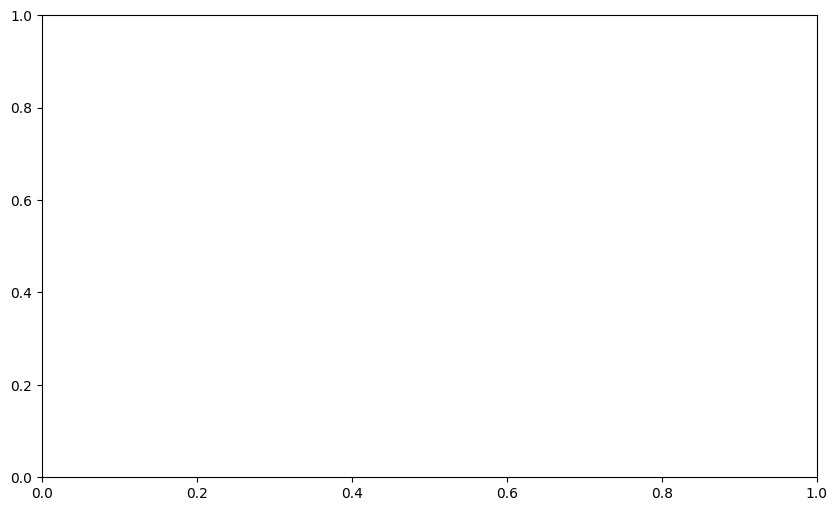

In [26]:
# Extract data
datasets = mean_df['dataset_name']
methods = ['new_max_diffusion_time',   'new_mean_diffusion_time', 'adaptative_shap_time']
# Keep only when scheduler is  0.5 or unsupervised
tmp_mean_df = mean_df[mean_df['scheduler'] == '0.5']
x = np.arange(len(datasets))  # the label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
# Sort by dimension and anomly ratio
tmp_mean_df = tmp_mean_df.sort_values(by=['dimension', 'anomaly_ratio'])
std_df = std_df.reindex(tmp_mean_df.index)
method_names_dict={
    "new_max_diffusion_time":"Max Diffusion Time",
    "new_mean_diffusion_time":"Mean Diffusion Time",
    "adaptative_shap_time": "SHAP"
}
# Create a bar for each method with error bars
for i, method in enumerate(methods):
    ax.bar(x + i * width, tmp_mean_df[method], width, yerr=std_df[method], label=method_names_dict[method], capsize=5)

# Add labels, title, and legend
ax.set_xlabel('Dataset Name')
ax.set_yscale('log')
ax.set_ylabel('Computation Time (log)')
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(datasets, rotation=45, ha='right')
plt.grid()
ax.legend()

In [32]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment", "scheduler"], suffixes=('_mean', '_std'))
# Keep only unsuperivsed
merged_df = merged_df[merged_df['scheduler'] == '0.5']
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["adaptative_shap_accuracy"] = merged_df.apply(
    lambda row: f"${row['adaptative_shap_accuracy_mean']:.2f}\pm{row['adaptative_shap_accuracy_std']:.2f})$", axis=1
)
merged_df["new_mean_diffusion_accuracy"] = merged_df.apply(
    lambda row: f"${row['new_mean_diffusion_accuracy_mean']:.2f}\pm{row['new_mean_diffusion_accuracy_std']:.2f})$", axis=1
)
merged_df["new_max_diffusion_accuracy"] = merged_df.apply(
    lambda row: f"${row['new_max_diffusion_accuracy_mean']:.2f}\pm{row['new_max_diffusion_accuracy_std']:.2f}$", axis=1
)
merged_df["grad_accuracy"] = merged_df.apply(
    lambda row: f"${row['grad_explanation_accuracy_mean']:.2f}\pm{row['grad_explanation_accuracy_std']:.2f}$", axis=1
)
    

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["shap_feature_importance_ndcg_mean", "shap_feature_importance_ndcg_std", 
                                    "mean_diffusion_ndcg_mean", "mean_diffusion_ndcg_std",
                                    "max_diffusion_ndcg_mean", "max_diffusion_ndcg_std",
                                    "grad_ndcg_mean", "grad_ndcg_std"
                            ])

# keep only the columns we want
merged_df = merged_df[["dataset_name", "adaptative_shap_accuracy", "new_mean_diffusion_accuracy", "new_max_diffusion_accuracy", "grad_accuracy"]]
# Pivot so that method of explanation are columns
print(merged_df.columns)
# Remove index
merged_df = merged_df.reset_index(drop=True)
merged_df

Index(['dataset_name', 'adaptative_shap_accuracy',
       'new_mean_diffusion_accuracy', 'new_max_diffusion_accuracy',
       'grad_accuracy'],
      dtype='object')


,dataset_name,adaptative_shap_accuracy,new_mean_diffusion_accuracy,new_max_diffusion_accuracy,grad_accuracy
0,"4d, 5% anomalies",$0.99\pm0.01)$,$0.99\pm0.01)$,$0.99\pm0.01$,$0.99\pm0.01$
1,"4d, 10% anomalies",$0.94\pm0.01)$,$0.94\pm0.01)$,$0.94\pm0.01$,$0.95\pm0.02$
2,"10d, 4% anomalies",$0.81\pm0.01)$,$0.82\pm0.01)$,$0.84\pm0.01$,$0.77\pm0.02$
3,"10d, 9% anomalies",$0.81\pm0.01)$,$0.86\pm0.01)$,$0.85\pm0.01$,$0.79\pm0.01$
4,"50d, 5% anomalies",$0.67\pm0.01)$,$0.67\pm0.02)$,$0.67\pm0.02$,$0.57\pm0.03$
5,"50d, 10% anomalies",$0.62\pm0.00)$,$0.61\pm0.01)$,$0.62\pm0.01$,$0.63\pm0.01$
6,"100d, 5% anomalies",$0.61\pm0.01)$,$0.62\pm0.01)$,$0.63\pm0.01$,$0.54\pm0.03$
7,"100d, 10% anomalies",$0.56\pm0.01)$,$0.56\pm0.01)$,$0.57\pm0.01$,$0.56\pm0.01$
8,"1000d, 5% anomalies",$0.48\pm0.01)$,$0.47\pm0.01)$,$0.47\pm0.01$,$0.45\pm0.03$
9,"1000d, 10% anomalies",$0.48\pm0.00)$,$0.52\pm0.00)$,$0.54\pm0.00$,$0.48\pm0.00$


In [29]:
latex_table = dataframe_to_latex(
    merged_df,
    column_format="l" + "c" * (merged_df.shape[1]),  # Adjust column format dynamically
    caption="Accuracy with Mean and Standard Deviation for Different Experiments and Datasets, model trained with unsupervised method",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \begin{tabular}{lccccc} \toprule  & dataset_name & adaptative_shap_accuracy & new_mean_diffusion_accuracy & new_max_diffusion_accuracy & grad_accuracy \\ \midrule \bottomrule \end{tabular} \caption{Accuracy with Mean and Standard Deviation for Different Experiments and Datasets, model trained with unsupervised method} \label{tab:mean_std} \end{table}


In [30]:
merged_df.columns

Index(['dataset_name', 'adaptative_shap_accuracy',
       'new_mean_diffusion_accuracy', 'new_max_diffusion_accuracy',
       'grad_accuracy'],
      dtype='object')

In [34]:
mean_df

,dataset_name,training_method,experiment,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,max_diffusion_ndcg,max_diffusion_time,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,mean_new_mean_diffusion_time,mean_new_max_diffusion_time,mean_adaptative_shap_time,Unnamed: 0.5,anomaly_ratio
14,"4d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1639.555657,0.234413,0.598000,0.0,0.904494,4.0,...,0.590000,0.435560,0.985342,0.589333,13.573468,0.007010,0.006816,0.012140,NaN,5.00
12,"4d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1652.393950,0.218782,0.530333,0.0,0.770258,4.0,...,0.500333,0.615977,0.942951,0.500000,27.538339,0.005506,0.005348,0.012057,NaN,10.00
8,"10d, 4% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1631.987101,0.234536,0.558902,0.0,0.924340,10.0,...,0.470171,0.887023,0.836561,0.485142,222.910516,0.017978,0.017936,0.077070,0.0,4.98
10,"10d, 9% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1604.685385,0.218807,0.667003,0.0,0.890129,10.0,...,0.568714,1.342577,0.885107,0.605874,447.932497,0.012988,0.012999,0.076041,NaN,9.90
18,"50d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1644.828769,0.245820,0.590667,0.0,0.891544,50.0,...,0.393047,4.823728,0.815240,0.502131,470.870327,0.085346,0.084985,0.230642,NaN,5.00
16,"50d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1660.854018,0.241109,0.889000,0.0,0.989107,50.0,...,0.553937,6.925580,0.720506,0.699393,916.375074,0.060259,0.059714,0.230820,0.0,10.00
6,"100d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1642.415147,0.215240,0.795333,0.0,0.952058,100.0,...,0.502309,8.866522,0.701652,0.612643,524.793547,0.141913,0.140713,0.490693,NaN,5.00
4,"100d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1631.980241,0.235644,0.785667,0.0,0.936794,100.0,...,0.445756,15.164558,0.677220,0.588726,1049.219371,0.121612,0.121286,0.491055,NaN,10.00
2,"1000d, 5% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1519.295667,0.154841,0.755200,0.0,0.882119,1000.0,...,0.364808,143.336174,0.487321,0.399056,1974.143466,NaN,NaN,NaN,NaN,5.00
0,"1000d, 10% anomalies",DSIL,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,0.5,1500.356625,0.164367,0.860333,0.0,0.940816,1000.0,...,0.461883,209.099481,0.509307,0.466512,3933.896589,NaN,NaN,NaN,NaN,10.00


In [27]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment", "scheduler"], suffixes=('_mean', '_std'))
# Step 2: Combine mean and std into a single column with "mean(std)" format

merged_df = merged_df[merged_df['scheduler'] == '0.5']
merged_df["adaptative_shap_nDCG"] = merged_df.apply(
    lambda row: f"${row['new_adaptative_shap_ndcg_mean']:.2f}\pm{row['new_adaptative_shap_ndcg_std']:.2f}$", axis=1
)
merged_df["new_mean_diffusion_nDCG"] = merged_df.apply(
    lambda row: f"${row['new_mean_diffusion_ndcg_mean']:.2f}\pm{row['new_mean_diffusion_ndcg_std']:.2f}$", axis=1
)
merged_df["new_max_diffusion_nDCG"] = merged_df.apply(
    lambda row: f"${row['new_max_diffusion_ndcg_mean']:.2f}\pm{row['new_max_diffusion_ndcg_std']:.2f}$", axis=1
)
merged_df["grad_nDCG"] = merged_df.apply(
    lambda row: f"${row['grad_ndcg_mean']:.2f}\pm{row['grad_ndcg_std']:.2f}$", axis=1
)

merged_df["adaptative_shap_accuracy"] = merged_df.apply(
    lambda row: f"${row['new_adaptative_shap_accuracy_mean']:.2f}\pm{row['new_adaptative_shap_accuracy_std']:.2f})$", axis=1
)
merged_df["new_mean_diffusion_accuracy"] = merged_df.apply(
    lambda row: f"${row['new_mean_diffusion_accuracy_mean']:.2f}\pm{row['new_mean_diffusion_accuracy_std']:.2f})$", axis=1
)
merged_df["new_max_diffusion_accuracy"] = merged_df.apply(
    lambda row: f"${row['new_max_diffusion_accuracy_mean']:.2f}\pm{row['new_max_diffusion_accuracy_std']:.2f}$", axis=1
)
merged_df["grad_accuracy"] = merged_df.apply(
    lambda row: f"${row['grad_explanation_accuracy_mean']:.2f}\pm{row['grad_explanation_accuracy_std']:.2f}$", axis=1
)
   
merged_df["adaptative_shap_time"] = merged_df.apply(
    lambda row: f"${row['new_adaptative_shap_time_mean']:.2f}\pm{row['new_adaptative_shap_time_std']:.2f})$", axis=1
)
merged_df["new_mean_diffusion_time"] = merged_df.apply(
    lambda row: f"${row['new_mean_diffusion_time_mean']:.2f}\pm{row['new_mean_diffusion_time_std']:.2f}$", axis=1
)
merged_df["new_max_diffusion_time"] = merged_df.apply(
    lambda row: f"${row['new_max_diffusion_time_mean']:.2f}\pm{row['new_max_diffusion_time_std']:.2f}$", axis=1
)
merged_df["grad_time"] = merged_df.apply(
    lambda row: f"${row['grad_explanation_time_mean']:.2f}\pm{row['grad_explanation_time_std']:.2f}$", axis=1
)

# keep only the columns we want
merged_df = merged_df[["dataset_name", "adaptative_shap_nDCG", "adaptative_shap_accuracy", "adaptative_shap_time","new_mean_diffusion_nDCG", "new_mean_diffusion_accuracy","new_mean_diffusion_time", "new_max_diffusion_nDCG", "new_max_diffusion_accuracy",   "new_max_diffusion_time", "grad_nDCG", "grad_accuracy", "grad_time"]]
# Pivot so that method of explanation are columns
print(merged_df.columns)
# Remove _ from columns names
merged_df.columns = [col.replace("_", " ") for col in merged_df.columns]

# Remove index
merged_df = merged_df.reset_index(drop=True)
merged_df

Index(['dataset_name', 'adaptative_shap_nDCG', 'adaptative_shap_accuracy',
       'adaptative_shap_time', 'new_mean_diffusion_nDCG',
       'new_mean_diffusion_accuracy', 'new_mean_diffusion_time',
       'new_max_diffusion_nDCG', 'new_max_diffusion_accuracy',
       'new_max_diffusion_time', 'grad_nDCG', 'grad_accuracy', 'grad_time'],
      dtype='object')


,dataset name,adaptative shap nDCG,adaptative shap accuracy,adaptative shap time,new mean diffusion nDCG,new mean diffusion accuracy,new mean diffusion time,new max diffusion nDCG,new max diffusion accuracy,new max diffusion time,grad nDCG,grad accuracy,grad time
0,"4d, 5% anomalies",$0.99\pm0.01$,$0.99\pm0.01)$,$1.83\pm0.10)$,$0.99\pm0.01$,$0.99\pm0.01)$,$1.07\pm0.03$,$0.99\pm0.01$,$0.99\pm0.01$,$1.05\pm0.02$,$0.59\pm0.04$,$0.99\pm0.01$,$0.09\pm0.12$
1,"4d, 10% anomalies",$0.94\pm0.01$,$0.94\pm0.01)$,$3.20\pm0.05)$,$0.94\pm0.01$,$0.94\pm0.01)$,$1.49\pm0.02$,$0.94\pm0.01$,$0.94\pm0.01$,$1.43\pm0.02$,$0.50\pm0.00$,$0.95\pm0.02$,$0.01\pm0.00$
2,"10d, 4% anomalies",$0.84\pm0.01$,$0.81\pm0.01)$,$10.80\pm0.75)$,$0.86\pm0.01$,$0.82\pm0.01)$,$2.63\pm0.08$,$0.81\pm0.01$,$0.84\pm0.01$,$2.58\pm0.01$,$0.44\pm0.03$,$0.77\pm0.02$,$0.01\pm0.01$
3,"10d, 9% anomalies",$0.84\pm0.01$,$0.81\pm0.01)$,$25.40\pm0.55)$,$0.89\pm0.01$,$0.86\pm0.01)$,$4.55\pm0.06$,$0.81\pm0.01$,$0.85\pm0.01$,$4.49\pm0.08$,$0.56\pm0.01$,$0.79\pm0.01$,$0.01\pm0.00$
4,"50d, 5% anomalies",$0.72\pm0.01$,$0.67\pm0.01)$,$34.28\pm1.75)$,$0.73\pm0.02$,$0.67\pm0.02)$,$12.96\pm0.11$,$0.63\pm0.02$,$0.67\pm0.02$,$12.98\pm0.18$,$0.36\pm0.02$,$0.57\pm0.03$,$0.15\pm0.22$
5,"50d, 10% anomalies",$0.68\pm0.00$,$0.62\pm0.00)$,$103.07\pm1.29)$,$0.67\pm0.01$,$0.61\pm0.01)$,$27.44\pm0.56$,$0.57\pm0.01$,$0.62\pm0.01$,$26.96\pm0.34$,$0.61\pm0.01$,$0.63\pm0.01$,$0.01\pm0.00$
6,"100d, 5% anomalies",$0.69\pm0.00$,$0.61\pm0.01)$,$96.58\pm2.19)$,$0.69\pm0.01$,$0.62\pm0.01)$,$27.77\pm2.59$,$0.57\pm0.01$,$0.63\pm0.01$,$27.71\pm2.50$,$0.47\pm0.02$,$0.54\pm0.03$,$0.01\pm0.00$
7,"100d, 10% anomalies",$0.63\pm0.01$,$0.56\pm0.01)$,$192.07\pm4.22)$,$0.62\pm0.01$,$0.56\pm0.01)$,$47.59\pm3.16$,$0.52\pm0.01$,$0.57\pm0.01$,$47.02\pm2.87$,$0.49\pm0.01$,$0.56\pm0.01$,$0.01\pm0.00$
8,"1000d, 5% anomalies",$nan\pmnan$,$nan\pmnan)$,$nan\pmnan)$,$0.48\pm0.01$,$0.47\pm0.01)$,$350.66\pm5.53$,$0.46\pm0.01$,$0.47\pm0.01$,$351.63\pm5.17$,$0.35\pm0.02$,$0.45\pm0.03$,$0.07\pm0.14$
9,"1000d, 10% anomalies",$nan\pmnan$,$nan\pmnan)$,$nan\pmnan)$,$0.54\pm0.00$,$0.52\pm0.00)$,$227.26\pm69.77$,$0.52\pm0.00$,$0.54\pm0.00$,$228.71\pm72.75$,$0.42\pm0.01$,$0.48\pm0.00$,$0.01\pm0.01$


In [ ]:
latex_table = dataframe_to_latex(
    merged_df,
    column_format="l" + "c" * (merged_df.shape[1]),  # Adjust column format dynamically
    caption="Caption",
    label="tab:label",
    index=False  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \begin{tabular}{lccccccccccccc} \toprule dataset name & adaptative shap nDCG & adaptative shap accuracy & adaptative shap time & new mean diffusion nDCG & new mean diffusion accuracy & new mean diffusion time & new max diffusion nDCG & new max diffusion accuracy & new max diffusion time & grad nDCG & grad accuracy & grad time \\ \midrule \bottomrule \end{tabular} \caption{Caption} \label{tab:label} \end{table}


In [30]:
mean_df.head()

,experiment,dataset_name,training_method,scheduler,training_time,inference_time,f1_score,random_seed,aucroc,dimension,...,mean_diffusion_accuracy,mean_diffusion_ndcg,mean_diffusion_time,max_diffusion_accuracy,max_diffusion_ndcg,max_diffusion_time,shap_explanation_accuracy,shap_feature_importance_ndcg,shap_explanation_time,anomaly_ratio
7,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"Synthetic 4d, 5\% anomalies",DSIL,0.5,1639.555657,0.234413,0.598000,0.0,0.904494,4.0,...,0.988674,0.591333,0.449232,0.986417,0.590000,0.435560,0.985342,0.589333,13.573468,5.0
17,DTEC_DSIL_deterministic_cosine_s0_T400_bins7,"Synthetic 4d, 5\% anomalies",DSIL,cosine,478.708964,0.034341,0.630000,0.0,0.912246,4.0,...,0.990298,0.624000,0.468619,0.989194,0.623333,0.430364,0.987083,0.622000,13.583279,5.0
27,DTEC_DSIL_deterministic_exponential_s0_T400_bins7,"Synthetic 4d, 5\% anomalies",DSIL,exponential,520.853785,0.032855,0.644000,0.0,0.915739,4.0,...,0.990466,0.638000,0.484306,0.990466,0.638000,0.416217,0.987326,0.636000,13.630575,5.0
37,DTEC_unsupervised_None_s0_T400_bins7,"Synthetic 4d, 5\% anomalies",unsupervised,unsupervised,143.458278,0.044466,0.714000,0.0,0.926116,4.0,...,0.994418,0.710000,0.376587,0.993450,0.709333,0.345386,0.988691,0.706000,9.362252,5.0
6,DTEC_DSIL_deterministic_0.5_s0_T400_bins7,"Synthetic 4d, 10\% anomalies",DSIL,0.5,1652.393950,0.218782,0.530333,0.0,0.770258,4.0,...,0.943585,0.500333,0.673983,0.943580,0.500333,0.615977,0.942951,0.500000,27.538339,10.0


In [31]:
merged_df.head()

,dataset_name,shap_accuracy,mean_diffusion_accuracy,max_diffusion_accuracy,grad_accuracy
0,"Synthetic 4d, 5\% anomalies",$0.59(0.04)$,$0.59(0.04)$,$0.59(0.04)$,$0.59(0.04)$
1,"Synthetic 4d, 5\% anomalies",$0.62(0.04)$,$0.62(0.04)$,$0.62(0.04)$,$0.62(0.04)$
2,"Synthetic 4d, 5\% anomalies",$0.64(0.03)$,$0.64(0.03)$,$0.64(0.03)$,$0.64(0.03)$
3,"Synthetic 4d, 5\% anomalies",$0.71(0.03)$,$0.71(0.03)$,$0.71(0.03)$,$0.70(0.03)$
4,"Synthetic 4d, 10\% anomalies",$0.50(0.00)$,$0.50(0.00)$,$0.50(0.00)$,$0.50(0.00)$


In [32]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment"], suffixes=('_mean', '_std'))
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["f1_score_str"] = merged_df.apply(
    lambda row: f"${row['f1_score_mean']:.2f}({row['f1_score_std']:.2f})$", axis=1
)
merged_df["aucroc_str"] = merged_df.apply(
    lambda row: f"${row['aucroc_mean']:.2f}({row['aucroc_std']:.2f})$", axis=1
)

    

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["aucroc_std", "aucroc_mean", 
                                    "f1_score_mean", "f1_score_std"])

# keep only the columns we want
merged_df = merged_df[["dataset_name", "experiment", "f1_score_str", "aucroc_str"]]
# Pivot so that method of explanation are columns
print(merged_df.columns)
# Remove index
merged_df = merged_df.reset_index(drop=True)
merged_df.head()

Index(['dataset_name', 'experiment', 'f1_score_str', 'aucroc_str'], dtype='object')


,dataset_name,experiment,f1_score_str,aucroc_str
0,"Synthetic 4d, 5\% anomalies",DTEC_DSIL_deterministic_0.5_s0_T400_bins7,$0.60(0.03)$,$0.90(0.01)$
1,"Synthetic 4d, 5\% anomalies",DTEC_DSIL_deterministic_cosine_s0_T400_bins7,$0.63(0.04)$,$0.91(0.01)$
2,"Synthetic 4d, 5\% anomalies",DTEC_DSIL_deterministic_exponential_s0_T400_bins7,$0.64(0.03)$,$0.92(0.01)$
3,"Synthetic 4d, 5\% anomalies",DTEC_unsupervised_None_s0_T400_bins7,$0.71(0.03)$,$0.93(0.01)$
4,"Synthetic 4d, 10\% anomalies",DTEC_DSIL_deterministic_0.5_s0_T400_bins7,$0.53(0.01)$,$0.77(0.01)$


In [33]:
mean_df.columns

Index(['experiment', 'dataset_name', 'training_method', 'scheduler',
       'training_time', 'inference_time', 'f1_score', 'random_seed', 'aucroc',
       'dimension', 'grad_explanation_accuracy', 'grad_explanation_time',
       'grad_ndcg', 'mean_diffusion_accuracy', 'mean_diffusion_ndcg',
       'mean_diffusion_time', 'max_diffusion_accuracy', 'max_diffusion_ndcg',
       'max_diffusion_time', 'shap_explanation_accuracy',
       'shap_feature_importance_ndcg', 'shap_explanation_time',
       'anomaly_ratio'],
      dtype='object')

In [34]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment"], suffixes=('_mean', '_std'))
# Keep only DSIL
merged_df = merged_df[merged_df['experiment'] == "DTEC_unsupervised_None_s0_T400_bins7"]

# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["shap_acc"] = merged_df.apply(
    lambda row: f"${row['shap_explanation_accuracy_mean']:.2f}({row['shap_explanation_accuracy_std']:.2f})$", axis=1
)
merged_df["mean_diffusion_acc"] = merged_df.apply(
    lambda row: f"${row['mean_diffusion_accuracy_mean']:.2f}({row['mean_diffusion_accuracy_std']:.2f})$", axis=1
)
merged_df["max_diffusion_acc"] = merged_df.apply(
    lambda row: f"${row['max_diffusion_accuracy_mean']:.2f}({row['max_diffusion_accuracy_std']:.2f})$", axis=1
)
merged_df["grad_acc"] = merged_df.apply(
    lambda row: f"${row['grad_explanation_accuracy_mean']:.2f}({row['grad_explanation_accuracy_std']:.2f})$", axis=1
)
    

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["shap_explanation_accuracy_mean", "shap_explanation_accuracy_std", 
                                    "mean_diffusion_accuracy_mean", "mean_diffusion_accuracy_std",
                                    "max_diffusion_accuracy_mean", "max_diffusion_accuracy_std",
                                    "grad_explanation_accuracy_mean", "grad_explanation_accuracy_std"
                            ])

# keep only the columns we want
merged_df = merged_df[["dataset_name", "shap_acc", "mean_diffusion_acc", "max_diffusion_acc", "grad_acc"]]
# Pivot so that method of explanation are columns
print(merged_df.columns)
# Remove index
merged_df = merged_df.reset_index(drop=True)


Index(['dataset_name', 'shap_acc', 'mean_diffusion_acc', 'max_diffusion_acc',
       'grad_acc'],
      dtype='object')


In [35]:
latex_table = dataframe_to_latex(
    merged_df,
    column_format="l" + "c" * (merged_df.shape[1]),  # Adjust column format dynamically
    caption="Accuracy Score with Mean and Standard Deviation for Different Experiments and Datasets, model is trained using DSIL",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

\begin{table}[ht] \centering \begin{tabular}{lccccc} \toprule  & dataset_name & shap_acc & mean_diffusion_acc & max_diffusion_acc & grad_acc \\ \midrule 0 & Synthetic 4d, 5\% anomalies & $0.99(0.01)$ & $0.99(0.00)$ & $0.99(0.01)$ & $0.97(0.02)$ \\ 1 & Synthetic 4d, 10\% anomalies & $0.91(0.02)$ & $0.90(0.02)$ & $0.90(0.01)$ & $0.93(0.02)$ \\ 2 & Synthetic 10d, 4\% anomalies & $0.70(0.03)$ & $0.66(0.04)$ & $0.61(0.05)$ & $0.59(0.06)$ \\ 3 & Synthetic 10d, 9\% anomalies & $0.85(0.01)$ & $0.77(0.01)$ & $0.74(0.01)$ & $0.72(0.01)$ \\ 4 & Synthetic 50d, 5\% anomalies & $0.81(0.01)$ & $0.59(0.02)$ & $0.58(0.02)$ & $0.61(0.01)$ \\ 5 & Synthetic 50d, 10\% anomalies & $0.65(0.03)$ & $0.54(0.01)$ & $0.52(0.01)$ & $0.51(0.03)$ \\ 6 & Synthetic 100d, 5\% anomalies & $0.68(0.01)$ & $0.57(0.02)$ & $0.53(0.02)$ & $0.57(0.02)$ \\ 7 & Synthetic 100d, 10\% anomalies & $0.55(0.01)$ & $0.57(0.01)$ & $0.55(0.01)$ & $0.51(0.01)$ \\ 8 & Synthetic 1000d, 5\% anomalies & $0.53(0.02)$ & $0.53(0.02)$ & $0.52(0.0

In [36]:
print(full_results_df['experiment'].unique())
print(full_results_df['dataset_name'].unique())

['DTEC_DSIL_deterministic_0.5_s0_T400_bins7'
 'DTEC_DSIL_deterministic_cosine_s0_T400_bins7'
 'DTEC_DSIL_deterministic_exponential_s0_T400_bins7'
 'DTEC_unsupervised_None_s0_T400_bins7']
['Synthetic 4d, 10\\% anomalies' 'Synthetic 50d, 10\\% anomalies'
 'Synthetic 10d, 9\\% anomalies' 'Synthetic 1000d, 10\\% anomalies'
 'Synthetic 1000d, 5\\% anomalies' 'Synthetic 10d, 4\\% anomalies'
 'Synthetic 100d, 10\\% anomalies' 'Synthetic 4d, 5\\% anomalies'
 'Synthetic 50d, 5\\% anomalies' 'Synthetic 100d, 5\\% anomalies']


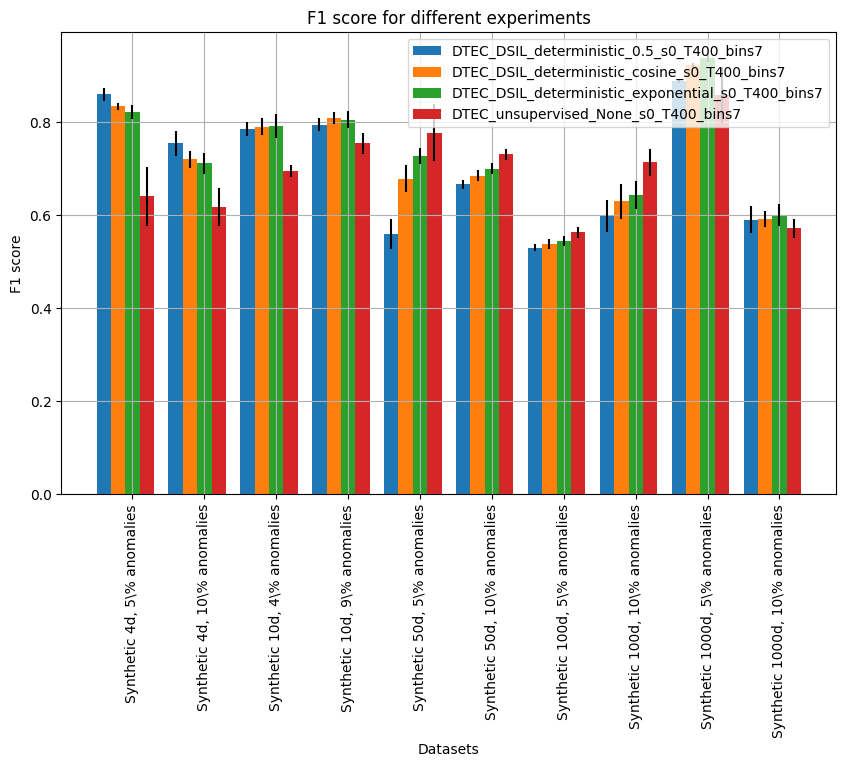

In [37]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="f1_score", ylabel="F1 score", title="F1 score for different experiments", synthetic=False)

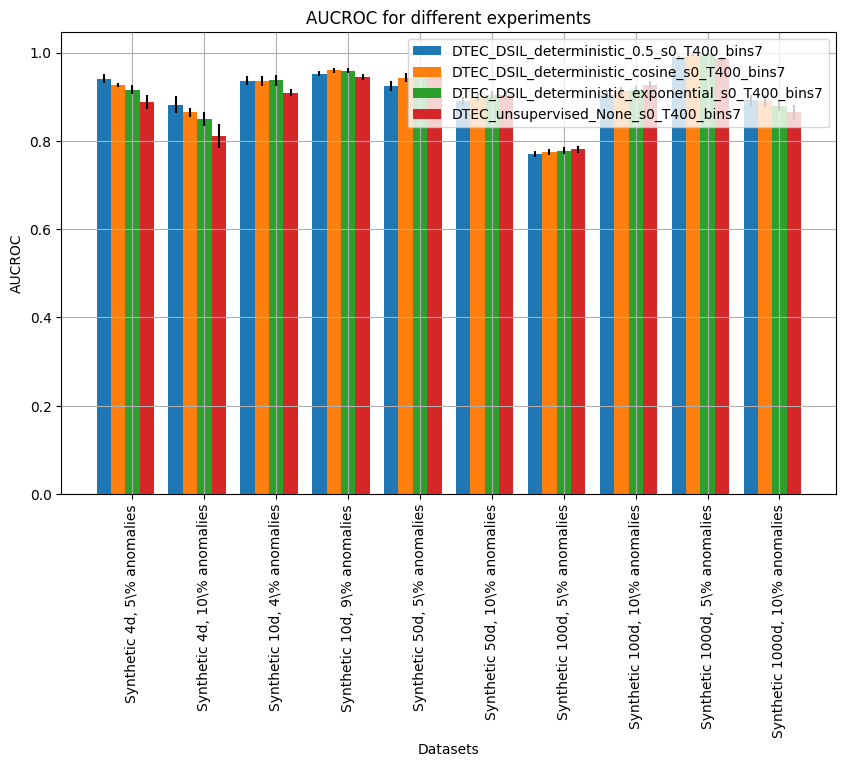

In [38]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="aucroc", ylabel="AUCROC", title="AUCROC for different experiments")

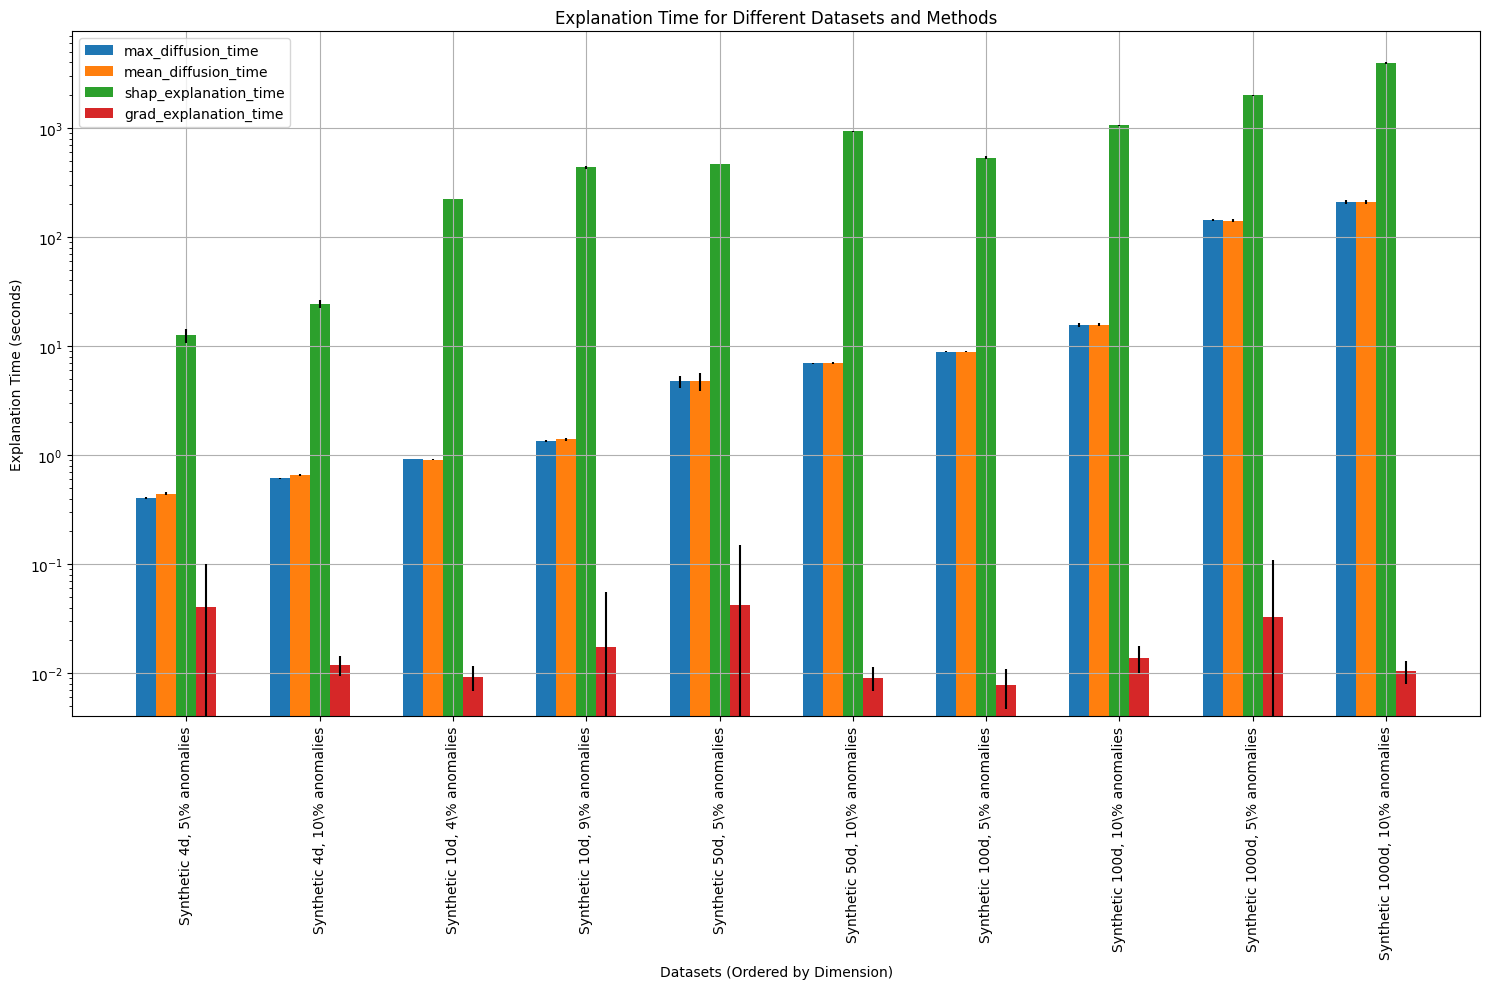

In [39]:
# Sort datasets by dimension
mean_df = mean_df.sort_values('dimension')
std_df = std_df.sort_values('dimension')
datasets = mean_df['dataset_name'].unique()

# Extract unique methods
methods = ["max_diffusion_time", "mean_diffusion_time", "shap_explanation_time", "grad_explanation_time"]
num_datasets = len(datasets)
num_methods = len(methods)

r = np.arange(num_datasets)
bar_width = 0.15  # Adjust bar width to fit the methods

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each method's average explanation time as a bar
for i, method in enumerate(methods):
    method_mean = mean_df.groupby("dataset_name")[method].mean().reindex(datasets)
    method_std = std_df.groupby("dataset_name")[method].std().reindex(datasets)
    ax.bar(r + i * bar_width, method_mean.values, width=bar_width, yerr=method_std.values, label=method)

# Add labels, title, and customize the x-axis
ax.set_xlabel('Datasets (Ordered by Dimension)')
ax.set_ylabel('Explanation Time (seconds)')
ax.set_title('Explanation Time for Different Datasets and Methods')
ax.set_xticks(r + bar_width * (num_methods ) / 2)
ax.set_xticklabels(datasets)
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yscale('log')
# Show the plot
plt.grid()
plt.tight_layout()
plt.show()


KeyError: 'ndcg_diff_shap_mean'

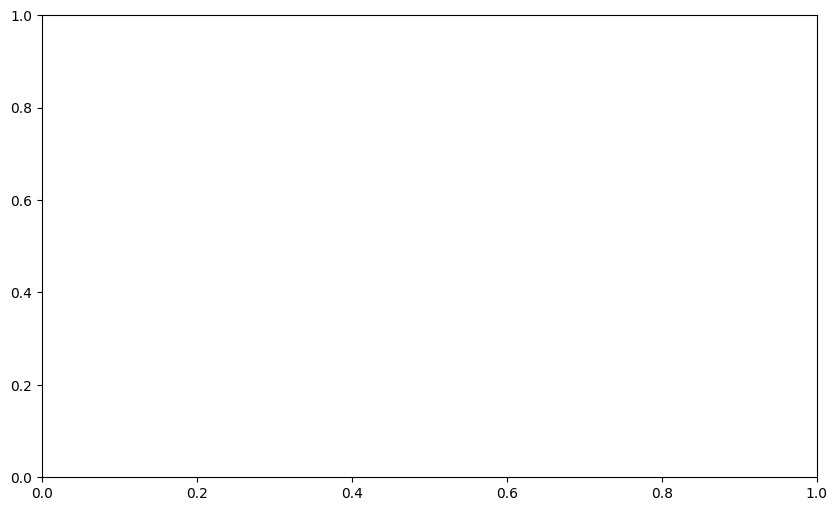

In [40]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_shap_mean", ylabel="nDCG SHAP - nDCG ours (mean)", title="nDCG difference between SHAP and our method (mean) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_shap_max", ylabel="acc shap - acc max", title="acc difference between shap and our method for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_shap_grad", ylabel="nDCG grad - nDCG SHAP", title="nDCG difference between SHAP and grad method for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_shap_mean", ylabel="accuracy SHAP - accuracy ours (mean)", title="Accuracy difference between SHAP and our method (mean) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_grad_mean", ylabel="accuracy grad - accuracy mean diffusion time perturbation", title="Accuracy difference between grad and our method (with mean) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="accuracy_diff_mean_max", ylabel="accuracy ours(mean) - accuracy ours (max)", title="Accuracy difference between our methods (mean and max) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_shap_max", ylabel="ndcg shap - ndcg ours (max)", title="nDCG difference between shap and max(our) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="ndcg_diff_mean_max", ylabel="ndcg ours(mean) - accuracy ours (max)", title="nDCG difference between our methods (mean and max) for different experiments")

In [ ]:
histogram_experiment(mean_df=mean_df, std_df=std_df, column="max_diffusion_accuracy", ylabel="max diffusion perturbation", title="accuracy for max diffusion perturbation for different experiments")

In [ ]:
mean_df.columns

In [ ]:
# Step 1: Merge DataFrames on common columns
merged_df = pd.merge(mean_df, std_df, on=["dataset_name", "experiment"], suffixes=('_mean', '_std'))
# Step 2: Combine mean and std into a single column with "mean(std)" format
merged_df["nDCG_acc"] = merged_df.apply(
    lambda row: f"${row['nDCG_mean']:.2f}({row['nDCG_std']:.2f})$", axis=1
)
merged_df["max_diffusion_acc"] = merged_df.apply(

# Step 3: Drop the separate mean and std columns if needed
merged_df = merged_df.drop(columns=["aucroc_mean", "aucroc_std"])
# Pivot so that experiment is the columns
merged_df = merged_df.pivot(index="dataset_name", columns="experiment", values="aucroc_str")
print(merged_df.columns)
merged_df.reset_index(inplace=True)

In [ ]:
latex_table = dataframe_to_latex(
    merged_df,
    column_format="llc",  
    caption="Mean and Standard Deviation of F1 score for Different Experiments and Datasets",
    label="tab:mean_std",
    index=False
)
with open("latex_table.tex", "w") as f:
    f.write(latex_table)
latex_table.replace("\n", " ")

In [ ]:
# Define a function to extract and sum all ratios from the dataset name
def extract_ratios(dataset_name):
    # Use re.findall to capture all numerical ratios
    ratios = re.findall(r'r([0-9]*\.?[0-9]+)|_([0-9]*\.?[0-9]+)', dataset_name)
    # Flatten the list of tuples and filter out empty strings
    ratios = [float(r) for pair in ratios for r in pair if r]
    # Return the sum of the ratios
    return f"{sum(ratios) * 100:.2f}"
def rename_row(dataset_name):
    return "synthetic {} - {}".format(re.search(r"f(\d+)", dataset_name).group(1), extract_ratios(dataset_name))
# In dataset name, keep only the word "synthetic" and the number of feature which is after "f_"ArithmeticError
merged_df['dataset_name'] = merged_df['dataset_name'].apply(rename_row)


# Step 4: Pivot the DataFrame to have experiments as columns and datasets as rows
pivot_df = merged_df.pivot(index="dataset_name", columns="experiment", values="f1_score_str")

# If there is NaN in a column, remove the column
pivot_df = pivot_df.replace("nan", np.nan)
pivot_df = pivot_df.dropna(axis=1)
# Same if its nan in a string "nan"
# Step 5: Convert the pivoted DataFrame to LaTeX
latex_table = dataframe_to_latex(
    pivot_df,
    column_format="l" + "c" * (pivot_df.shape[1]),  # Adjust column format dynamically
    caption="F1 Score with Mean and Standard Deviation for Different Experiments and Datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

In [ ]:
# Turn nDCG and accuracy to string
merged_df["shape_nDCG_str"] = merged_df.apply(
    lambda row: f"${row['shap_feature_importance_ndcg_mean']:.2f}({row['shap_feature_importance_ndcg_std']:.2f})$", axis=1)
merged_df["shape_accuracy_str"] = merged_df.apply(
    lambda row: f"${row['shap_explanation_accuracy_mean']:.2f}({row['shap_explanation_accuracy_std']:.2f})$", axis=1
)
merged_df['local_nDCG_srt'] = merged_df.apply(
    lambda row: f"${row['feature_importance_ndcg_mean']:.2f}({row['feature_importance_ndcg_std']:.2f})$", axis=1
)
merged_df['local_accuracy_str'] = merged_df.apply(
    lambda row: f"${row['feature_importance_accuracy_mean']:.2f}({row['feature_importance_accuracy_std']:.2f})$", axis=1
)
merged_df['grad_nDCG_str'] = merged_df.apply(
    lambda row: f"${row['grad_feature_importance_ndcg_mean']:.2f}({row['grad_feature_importance_ndcg_std']:.2f})$", axis=1
)
merged_df['grad_accuracy_str'] = merged_df.apply(
    lambda row: f"${row['grad_explanation_accuracy_mean']:.2f}({row['grad_explanation_accuracy_std']:.2f})$", axis=1
)

In [ ]:
# Step 4: Pivot the DataFrame to have experiments as columns and datasets as rows
pivot_df = merged_df.pivot(index="dataset_name", columns="experiment", values=["shape_nDCG_str", "shape_accuracy_str", "local_nDCG_srt", "local_accuracy_str", "grad_nDCG_str", "grad_accuracy_str"])

# If there is NaN in a column, remove the column
pivot_df = pivot_df.replace("nan", np.nan)
pivot_df = pivot_df.dropna(axis=1)
pivot_df

In [ ]:
# Same if its nan in a string "nan"
# Step 5: Convert the pivoted DataFrame to LaTeX
latex_table = dataframe_to_latex(
    pivot_df,
    column_format="l" + "c" * (pivot_df.shape[1]),  # Adjust column format dynamically
    caption="F1 Score with Mean and Standard Deviation for Different Experiments and Datasets",
    label="tab:mean_std",
    index=True  # Include the row index (datasets)
)

# Save the LaTeX table to a file
with open("latex_table.tex", "w") as f:
    f.write(latex_table)

# Optional: Print the LaTeX table for verification
print(latex_table.replace("\n", " "))

In [ ]:
merged_df.columns

In [ ]:
dataframe_to_latex(
    merged_df[['experiment', 'dataset_name', 'shap_feature_importance_ndcg_m', 'grad_feature_importance_ndcg', 'feature_importance_ndcg', "shap_explanation_accuracy_mean", "grad_explanation_accuracy_mean", "local_explanation_accuracy_mean"]],
    column_format="llccc",  
    caption="NDCG for Different Experiments and Datasets",
    label="tab:ndcg",
    index=False
)

In [ ]:
baseline_comp_dataset = pd.DataFrame()
temp_df = full_results_df
temp_df['dataset_name'] = temp_df['dataset_name'] + "_" + temp_df['dataset_version']
for dataset_name in full_results_df["dataset_name"].unique():
    dataset_results = full_results_df[full_results_df["dataset_name"] == dataset_name]
    baseline_results = dataset_results[dataset_results["training_method"] == "unsupervised"]
    dataset_results['f1_score_diff'] = dataset_results['f1_score'] - baseline_results['f1_score'].values[0]
    dataset_results['aucroc_diff'] = dataset_results['aucroc'] - baseline_results['aucroc'].values[0]
    dataset_results['aucroc_ratio'] = dataset_results['aucroc'] / baseline_results['aucroc'].values[0]
    dataset_results['f1_score_ratio'] = dataset_results['f1_score'] / baseline_results['f1_score'].values[0]
    dataset_results['feature_importance_ndcg_diff'] = dataset_results['feature_importance_ndcg'] - baseline_results['feature_importance_ndcg'].values[0]
    dataset_results['shap_feature_importance_ndcg_diff'] = dataset_results['shap_feature_importance_ndcg'] - baseline_results['shap_feature_importance_ndcg'].values[0]
    baseline_comp_dataset = pd.concat([baseline_comp_dataset, dataset_results]) 